1 Data Acquisition – downloading, aggregation, ...
2 Pre-Processing – converting the data into a logical representation.
3 Knowledge Discovery – the logical representation is analysed and new
useful knowledge is discovered.
4 Validation of Discovered Knowledge – using measures such as
frequency filters, support and confidence metrics.
5 Data Visualisation.

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import itertools

# from google.colab import drive
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import NuSVR


# drive.mount('/content/drive')
# os.chdir('//content/drive/MyDrive/1. Educ/1. Masters/Year 1/ICS5110 - Applied Machine Learning/1. Personal Assignment/Git Repo/applied_ml_assignment')
# print(os.getcwd())


In [3]:
#Loading cleaned data from CVS
training_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")
# validation_data = pd.read_csv("data/validate_data.csv")

training_data['Date'] = pd.to_datetime(training_data['Date'])

display(training_data.head(5))

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tmin,tavg,tmax
0,2003-01-01,0.36,182.08,0.0,0.0,45.69,4.82,398.58,10.9,13.2,15.6
1,2003-02-01,0.40,187.10,0.0,0.0,46.95,4.82,398.58,7.9,10.4,13.0
2,2003-03-01,0.34,176.37,0.0,0.0,44.26,4.82,398.58,9.8,12.7,15.7
3,2003-04-01,0.30,156.53,0.0,0.0,39.28,4.82,398.58,12.4,15.5,18.7
4,2003-05-01,0.28,163.97,0.0,0.0,41.15,4.82,398.58,16.0,20.4,24.8


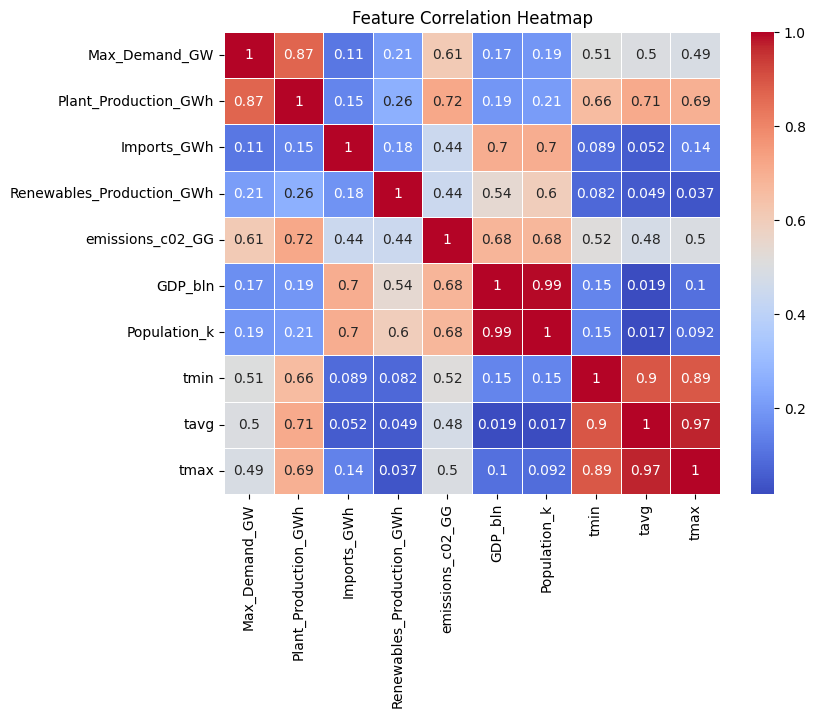

In [4]:
#Building correlation matrices to understand dataset and features
featuresToDrop = ['Date']
correlation_matrix = training_data.drop(columns=featuresToDrop).corr()

# Plot a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

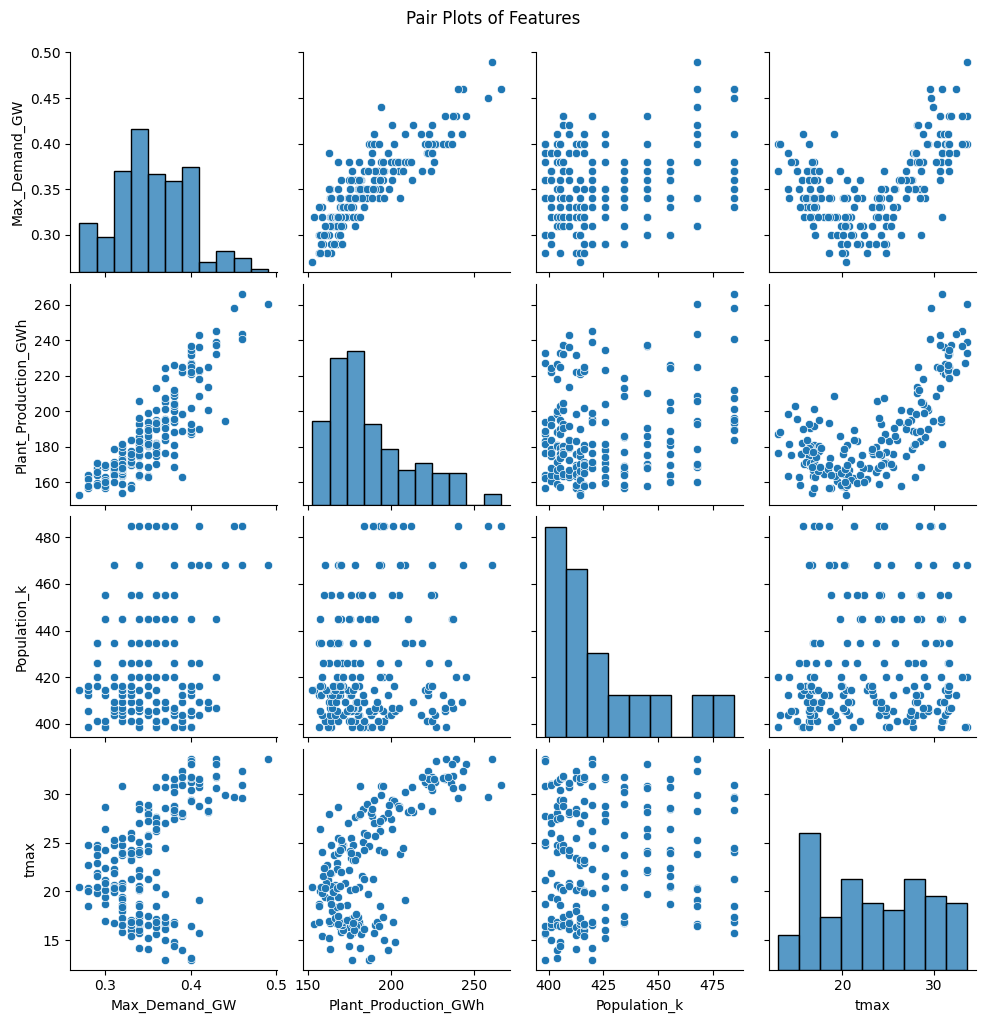

In [5]:
# Extract features excluding the below items
featuresToDrop = ['GDP_bln', 'tmin', 'tavg', 'emissions_c02_GG', 'Renewables_Production_GWh','Imports_GWh']
datasetToPlot = training_data.drop(columns=featuresToDrop)
selected_features = datasetToPlot.columns[1:]

# Create pair plots using Seaborn
sns.pairplot(training_data[selected_features])
plt.suptitle('Pair Plots of Features', y=1.02)
plt.show()


In [6]:
# Create a Plotly trace for a 3D scatter plot
trace = go.Scatter3d(
    x=training_data['Plant_Production_GWh'],
    y=training_data['Imports_GWh'],
    z=training_data['emissions_c02_GG'],
    mode='markers',
    marker=dict(
        size=5,
        color=training_data['emissions_c02_GG'],  # Color by z-value for example
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Plant Production'),
        yaxis=dict(title='Imports'),
        zaxis=dict(title='CO2')
    )
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [7]:
# Create a Plotly trace for a 3D scatter plot
trace = go.Scatter3d(
    x=training_data['tmax'],
    y=training_data['Population_k'],
    z=training_data['Max_Demand_GW'],
    mode='markers',
    marker=dict(
        size=5,
        color=training_data['Max_Demand_GW'],  # Color by z-value for example
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='tmax'),
        yaxis=dict(title='population'),
        zaxis=dict(title='max_demand')
    )
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

The model produced by support vector classification depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin. Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function ignores samples whose prediction is close to their target.



Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be done easily by using a Pipeline

https://scikit-learn.org/stable/modules/svm.html

In [24]:
# Calculating the MAPE on the Validation dataset
def mean_absolute_percentage_error(actual, predictions): 
    actual, predictions = np.array(actual), np.array(predictions)
    return np.mean(np.abs((actual - predictions) / actual)) * 100



C:\Users\spichr01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but SVR was fitted without feature names



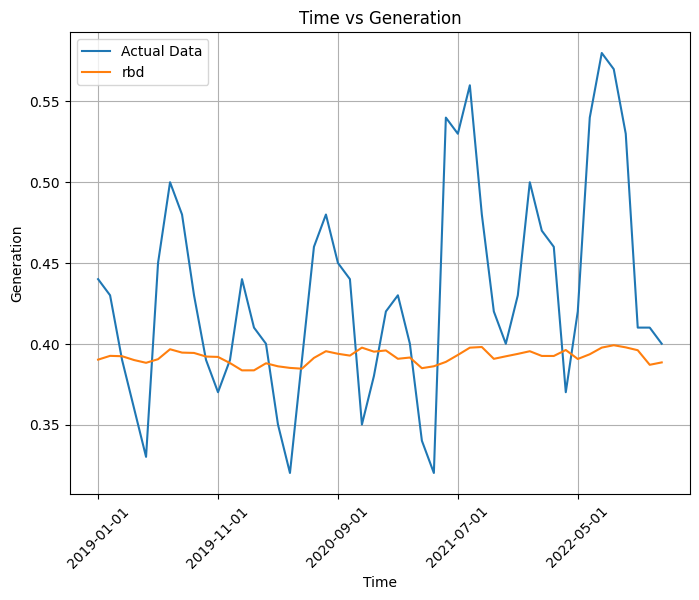

Mean Squared Error: 0.005661385271573174


In [8]:
selectedFeatures = ['GDP_bln','tmax', 'Population_k','Renewables_Production_GWh','Imports_GWh']
selectedTarget = ['Max_Demand_GW']

feature_ToTrain = training_data[selectedFeatures]
target_ToTrain = training_data[selectedTarget]

feature_ToTest = test_data[selectedFeatures]
target_ToTest = test_data[selectedTarget]

feature_ToTrain = feature_ToTrain.to_numpy()
target_ToTrain = target_ToTrain.to_numpy().ravel()

svm_regressor = SVR(kernel='rbf', C=2, gamma='scale')  # You can specify different kernels like 'linear', 'poly', 'rbf', etc.
svm_regressor.fit(feature_ToTrain, target_ToTrain)

# Making predictions
target_pred = svm_regressor.predict(feature_ToTest)

# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(test_data['Date'], target_ToTest, linestyle='-', label="Actual Data")
plt.plot(test_data['Date'], target_pred, linestyle='-', label = "rbd")

n = 10
plt.xticks(np.arange(0, len(test_data['Date']), n), [test_data['Date'][i] for i in range(0, len(test_data['Date']), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

# Evaluating the model (example using Mean Squared Error)
mse = mean_squared_error(target_ToTest, target_pred)
print(f"Mean Squared Error: {mse}")

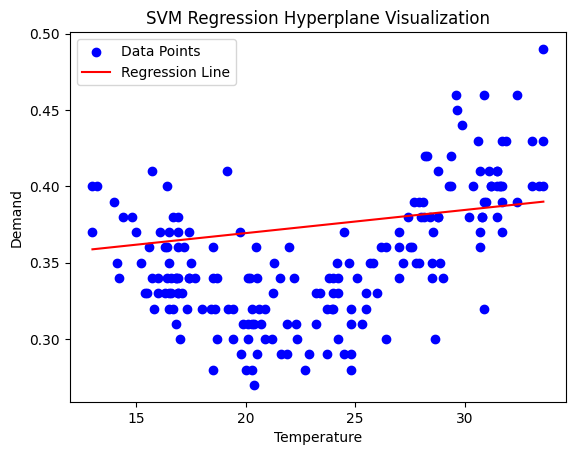

In [9]:
# selectedFeatures = ['GDP_bln','tmax', 'Population_k','Renewables_Production_GWh','Imports_GWh']
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

feature_ToTrain = training_data[selectedFeatures]
target_ToTrain = training_data[selectedTarget]

feature_ToTrain = feature_ToTrain.to_numpy()
target_ToTrain = target_ToTrain.to_numpy().ravel()

feature_ToTest = test_data[selectedFeatures]
target_ToTest = test_data[selectedTarget]

# Creating and fitting the SVM regression model
svm = SVR(kernel='linear', C=1.0)
svm.fit(feature_ToTrain, target_ToTrain)

# Get the weights and bias term
w = svm.coef_[0]
b = svm.intercept_[0]

# Plotting the data points
plt.scatter(feature_ToTrain, target_ToTrain, c='blue', label='Data Points')

# Plotting the hyperplane
x_values = np.linspace(np.min(feature_ToTrain), np.max(feature_ToTrain), 100)
y_values = w * x_values + b

plt.plot(x_values, y_values, color='red', label='Regression Line')

plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('SVM Regression Hyperplane Visualization')
plt.legend()
plt.show()

The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.




Gamma Range:
Small Gamma:

gamma < 1: A smaller gamma implies a larger range of influence for each support vector. The decision boundary tends to be smoother, and the model might generalize better.
Large Gamma:

gamma > 1: A larger gamma shrinks the range of influence of support vectors, making the decision boundary more 'wiggly' to fit closely to individual data points.
gamma = 'auto' or 'scale': In scikit-learn, 'auto' or 'scale' settings automatically set the value of gamma. 'auto' uses 1/n_features, and 'scale' uses 1/(n_features * X.var()).
Impact:
Higher gamma: Can lead to overfitting, especially with smaller datasets or noisy data, as the model might adapt too closely to the training data.
Lower gamma: Tends to produce smoother decision boundaries, aiding in better generalization to unseen data.



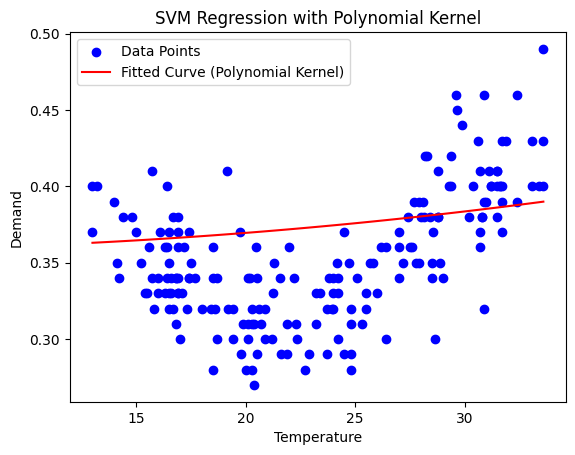

In [10]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

feature_poly = training_data[selectedFeatures]
target_poly = training_data[selectedTarget]

feature_poly = feature_poly.to_numpy()
target_poly = target_poly.to_numpy().ravel()

# Creating and fitting the SVM regression model with a polynomial kernel
svm_poly = SVR(kernel='poly', degree=2, C=10, gamma='auto')
svm_poly.fit(feature_poly, target_poly)

# Plotting the data points
plt.scatter(feature_poly, target_poly, c='blue', label='Data Points')

# Plotting the predicted curve
x_values = np.linspace(np.min(feature_poly), np.max(feature_poly), 100)
y_values = svm_poly.predict(x_values.reshape(-1, 1))  # Reshaping for prediction

plt.plot(x_values, y_values, color='red', label='Fitted Curve (Polynomial Kernel)')

plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('SVM Regression with Polynomial Kernel')
plt.legend()
plt.show()

**Normalizing**

**Standardization (Z-score normalization):**
Method: Subtract the mean and scale by the standard deviation for each feature.
Benefits: Useful when features have different units or different ranges.

**Min-Max Scaling (Normalization):**
Method: Scale features to a specific range, often [0, 1].
Benefits: Useful when algorithms require inputs to be in a specific range.

**Robust Scaling:**
Method: Scale features using median and interquartile range (IQR) to make them robust to outliers.
Benefits: Useful when data contains outliers.

**Log Transformation:**
Method: Apply logarithmic transformation to the data to handle skewed distributions or to emphasize relative changes.
Benefits: Useful when the data is heavily skewed.

**Which to Choose:**
Use standardization (StandardScaler in scikit-learn) when features have varying scales and roughly Gaussian-like distributions.
Use min-max scaling (MinMaxScaler in scikit-learn) when the algorithm requires input in a specific range.
Use robust scaling (RobustScaler in scikit-learn) when the dataset contains outliers.
Use log transformation if the data has a heavily skewed distribution.


ChatGPT

In [11]:
# selectedFeatures = ['GDP_mln','tmax', 'Population_k']
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

scaler = StandardScaler()  # StandardScaler, MinMaxScaler, RobustScaler, etc.

feature_normTrain= scaler.fit_transform(training_data[selectedFeatures])
target_normTrain = training_data[selectedTarget].to_numpy().ravel()

feature_normTest = scaler.fit_transform(test_data[selectedFeatures])
target_normTest = test_data[selectedTarget].to_numpy().ravel()

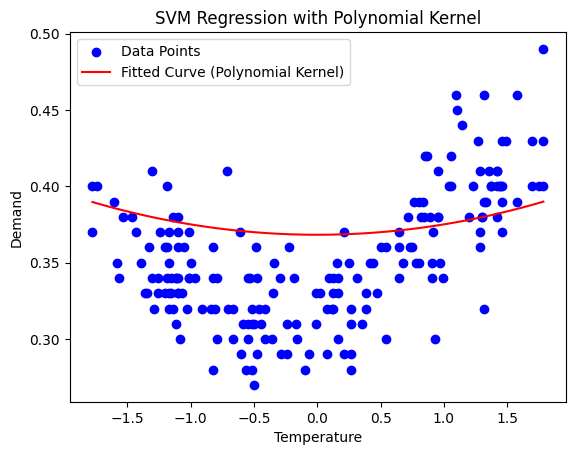

In [12]:
# Creating and fitting the SVM regression model with a polynomial kernel
# svm_poly_norm = SVR(kernel='poly', degree=2, C=10, gamma='auto')
svm_poly_norm = SVR(kernel='poly', degree=2, C=0.1, gamma='auto')
svm_poly_norm.fit(feature_normTrain, target_normTrain)

# Plotting the data points
plt.scatter(feature_normTrain, target_normTrain, c='blue', label='Data Points')

# Plotting the predicted curve
x_values = np.linspace(np.min(feature_normTrain), np.max(feature_normTrain), 100)
y_values = svm_poly_norm.predict(x_values.reshape(-1, 1))  # Reshaping for prediction

plt.plot(x_values, y_values, color='red', label='Fitted Curve (Polynomial Kernel)')

plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('SVM Regression with Polynomial Kernel')
plt.legend()
plt.show()

Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

https://scikit-learn.org/stable/modules/svm.html

In [13]:
# Define the parameter grid to search through
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create the SVR model
svm_regressor = SVR(kernel='rbf')

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=svm_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV instance on your data
grid_search.fit(feature_normTrain, target_normTrain)

# Retrieve the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Negative MSE:", best_score)

Best Parameters: {'C': 0.1, 'gamma': 0.1}
Best Negative MSE: -0.0022010134921927682


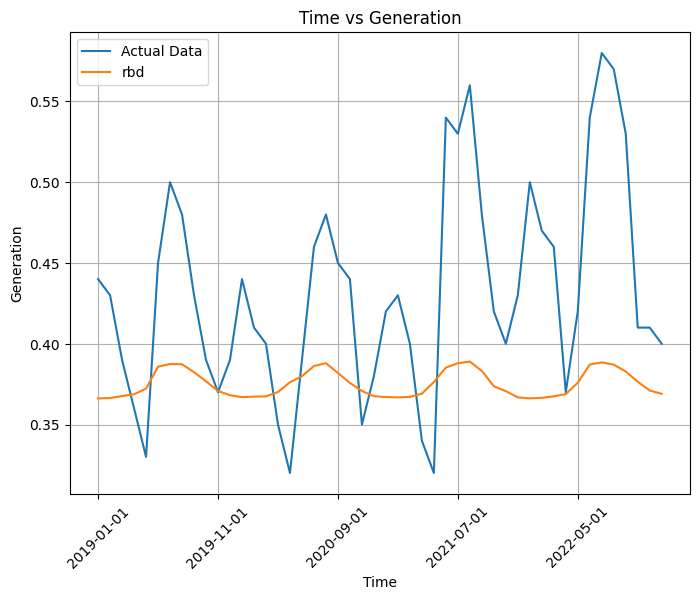

Mean Squared Error: 0.006975930140595763


In [14]:
svm_regressor = SVR(kernel='rbf', C=0.1, gamma=0.1)
svm_regressor.fit(feature_normTrain, target_normTrain)

# Making predictions
target_pred = svm_regressor.predict(feature_normTest)

# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(test_data['Date'], target_normTest, linestyle='-', label="Actual Data")
plt.plot(test_data['Date'], target_pred, linestyle='-', label = "rbd")

n = 10
plt.xticks(np.arange(0, len(test_data['Date']), n), [test_data['Date'][i] for i in range(0, len(test_data['Date']), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

# Evaluating the model (example using Mean Squared Error)
mse = mean_squared_error(target_ToTest, target_pred)
print(f"Mean Squared Error: {mse}")

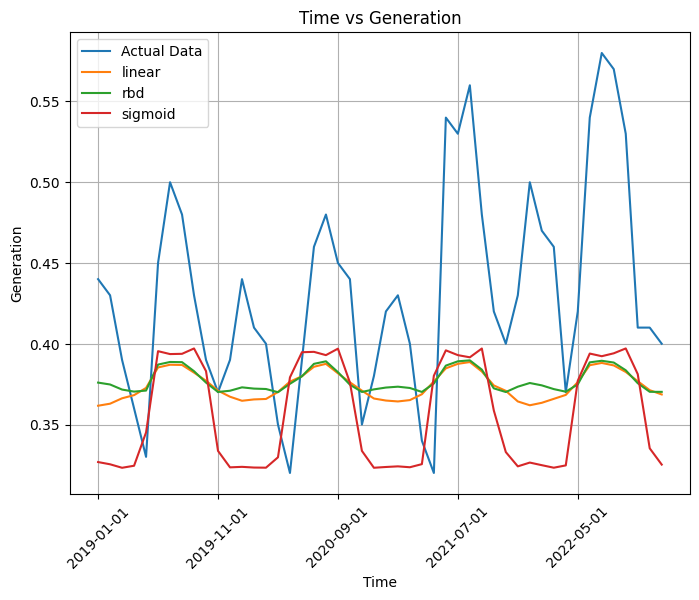

In [15]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

x_Time = test_data['Date']
target_Test = test_data[selectedTarget]

model_linear = SVR(kernel='linear')
model_linear.feature_names = selectedFeatures
model_linear.fit(feature_normTrain, target_normTrain)
target_pred_linear = model_linear.predict(feature_normTest)


model_poly = SVR(kernel='poly', degree=2, C=0.1, gamma=0.1)
model_poly.feature_names = selectedFeatures
model_poly.fit(feature_normTrain, target_normTrain)
target_pred_poly = model_poly.predict(feature_normTest)


model_rbf = SVR(kernel='rbf', gamma='scale')
model_rbf.feature_names = selectedFeatures
model_rbf.fit(feature_normTrain, target_normTrain)
target_pred_rbf = model_rbf.predict(feature_normTest)

model_sigmoid = SVR(kernel='sigmoid', gamma='scale')
model_sigmoid.feature_names = selectedFeatures
model_sigmoid.fit(feature_normTrain, target_normTrain)
target_pred_sigmoid = model_sigmoid.predict(feature_normTest)


# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(x_Time, target_normTest, linestyle='-', label="Actual Data")
plt.plot(x_Time, target_pred_linear, linestyle='-', label="linear")
# plt.plot(x_Time, y_pred_poly, linestyle='-', label = "poly")
plt.plot(x_Time, target_pred_rbf, linestyle='-', label = "rbd")
plt.plot(x_Time, target_pred_sigmoid, linestyle='-', label="sigmoid")

n = 10
plt.xticks(np.arange(0, len(x_Time), n), [x_Time[i] for i in range(0, len(x_Time), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

The model is still not behaving as expected. Since the issue lies with the parameters chosen, range() and itertools.product() are to be used to efficiently explore a grid of hyperparameters for an SVM regression model through different combinations. Sigmoid kernel is going to be used since it gave best results based on the above experiments


**CROSS VALIDATION**

Cross-Validation: It's a technique used to assess how well a model generalizes to an independent dataset. Instead of using a single split of the data into training and validation sets, cross-validation divides the dataset into k subsets (folds) and performs training and validation k times, each time using a different fold as the validation set and the remaining folds as the training set.

cv=5: This specifies that the cross-validation process will be performed using 5 folds. The dataset will be divided into 5 subsets, and the model will be trained and validated 5 times. In each iteration, one of the 5 subsets will be used as the validation set, and the remaining 4 subsets will be used for training. This process will be repeated 5 times, ensuring that each subset is used as the validation set exactly once.

The performance metrics (such as accuracy, mean squared error, etc.) obtained from each of the 5 iterations are typically averaged to provide an overall performance estimate of the model.

Choosing the number of folds (cv) depends on various factors like the size of your dataset, computational resources, and the trade-off between variance in the estimates and the amount of data used for training and validation. Common values for cv include 5, 10, or using techniques like leave-one-out cross-validation (cv=n, where n is the number of samples).

In the context of hyperparameter tuning using GridSearchCV, specifying cv=5 means the grid search will assess model performance based on 5-fold cross-validation, helping to provide a more robust estimation of how well the model might generalize to unseen data. Adjusting cv may impact the model's performance estimation and the computational time required for the grid search.



**SCORING**

Mean Squared Error (MSE): It measures the average squared difference between predicted values and actual values. It's a common metric for regression problems. Lower MSE values indicate better performance, as they represent smaller prediction errors.
However, in Scikit-learn's GridSearchCV, the scoring parameter typically takes metrics to maximize rather than minimize. To handle metrics that need to be minimized (like MSE), Scikit-learn uses a convention where it negates the value of the metric. This means that the neg_mean_squared_error computes the negative of MSE, effectively turning the minimization problem into a maximization one.

So, when using neg_mean_squared_error as the scoring metric, the goal is to find hyperparameters that maximize the negative MSE, which is equivalent to minimizing the MSE itself.


Other Metrics:

Regression

‘explained_variance’
‘max_error’
‘neg_mean_absolute_error’
‘neg_mean_squared_error’
‘neg_root_mean_squared_error’
‘neg_mean_squared_log_error’
‘neg_median_absolute_error’
‘r2’
‘neg_mean_poisson_deviance’
‘neg_mean_gamma_deviance’
‘neg_mean_absolute_percentage_error’
‘d2_absolute_error_score’
‘d2_pinball_score’
‘d2_tweedie_score’

In [16]:
# Define ranges for C and gamma
C_values = [0.1, 1, 10]  # Range from 1 to 100 with a step of 10
gamma_values = [0.01, 0.1, 1, 10]  # Specific gamma values
epsilon_values = [0.1, 0.2, 0.5]  # Specific epsilon values


# Define a range for C
# C_start = 0.1
# C_stop = 3
# C_step = 0.1
# C_values = list(range(int(C_start * 10), int(C_stop * 10) + 1, int(C_step * 10)))  # Granular range for C

# # Define a range for gamma
# gamma_start = 0.1
# gamma_stop = 1
# gamma_step = 0.1
# gamma_values = list(range(int(gamma_start * 10), int(gamma_stop * 10) + 1, int(gamma_step * 10)))  # Granular range for gamma

# # Define a range for epsilon
# epsilon_start = 0.1
# epsilon_stop = 1
# epsilon_step = 0.1
# epsilon_values = list(range(int(epsilon_start * 10), int(epsilon_stop * 10) + 1, int(epsilon_step * 10)))  # Granular range for epsilon

# Create the parameter grid using itertools.product
param_grid = {
    'C': C_values,
    'gamma': gamma_values,
    'epsilon': epsilon_values
}

param_combinations = list(itertools.product(*param_grid.values()))

# Create the SVR model
svr = SVR(kernel='rbf')

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=svr, param_grid={}, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Set the param_grid attribute to the generated parameter grid
grid_search.param_grid = {param: values for param, values in zip(param_grid.keys(), zip(*param_combinations))}

# Fit the GridSearchCV instance on your data
grid_search.fit(feature_normTrain, target_normTrain)

# Retrieve the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


print(best_params)
print(best_score)

{'C': 1, 'epsilon': 0.1, 'gamma': 0.01}
-0.002163635356588408


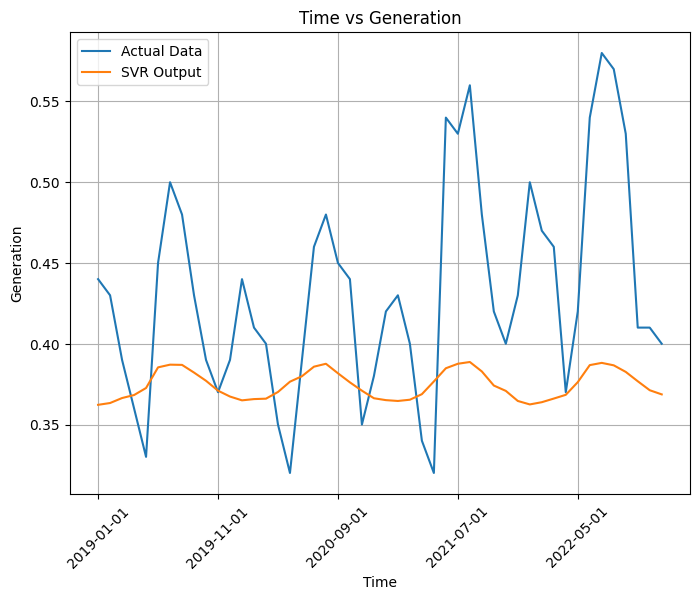

In [17]:
model_reTest = SVR(kernel='rbf', C=1, epsilon=0.1, gamma=0.01)
# model_reTest = SVR(kernel='sigmoid')
model_reTest.fit(feature_normTrain, target_normTrain)
target_pred_reTest = model_reTest.predict(feature_normTest)


# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(x_Time, target_normTest, linestyle='-', label="Actual Data")
plt.plot(x_Time, target_pred_reTest, linestyle='-', label="SVR Output")

n = 10
plt.xticks(np.arange(0, len(x_Time), n), [x_Time[i] for i in range(0, len(x_Time), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

 SelectFromModel using an SVR (Support Vector Regression) model with importance_getter='auto' - the feature selector is expecting the underlying estimator (in this case, the SVR model) to have either coef_ or feature_importances_ attribute available for feature selection.

**In the case of SVR, it doesn't have a coef_ attribute by default, as it doesn't provide direct coefficients like linear regression. SVR relies on support vectors, not coefficients, for prediction.**

To resolve:

Selecting an Attribute Manually:

Specify the attribute explicitly using importance_getter to access specific properties from the SVR model. For instance, you could set importance_getter='coef_' if you're looking for coefficients, although SVR doesn't provide direct coefficients.

Use a Different Feature Selector:

Consider using other feature selection methods that are not dependent on coef_ or feature_importances_. For SVR, *Recursive Feature Elimination (RFE)* or Sequential Feature Selection might be more appropriate.
Manually Extracting Feature Importance:

For SVR, calculate or derive feature importance using other techniques specific to the problem domain or by analyzing the support vectors' influence on predictions.

In [19]:
selectedFeaturesToTest = ['tmax', 'Population_k','emissions_c02_GG', 'Plant_Production_GWh' ]
selectedTargetToTest = ['Max_Demand_GW']

x_getFeatures = training_data[selectedFeaturesToTest]
y_getFeatures = training_data[selectedTargetToTest]

x_getFeatures = x_getFeatures.to_numpy()
y_getFeatures = y_getFeatures.to_numpy().ravel()

svr = SVR(kernel='linear')
svr.fit(x_getFeatures, y_getFeatures)

# Initialize RFE
rfe = RFE(estimator=svr, n_features_to_select=3)  # Choose the number of features you want to select

# Fit RFE
rfe.fit(x_getFeatures, y_getFeatures)

# Selected features
X_selected = rfe.transform(x_getFeatures)
# display(X_selected)

Trying out the 'pipeline' method to make sure that the data is correctly normalized throughout when working above.

C:\Users\spichr01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



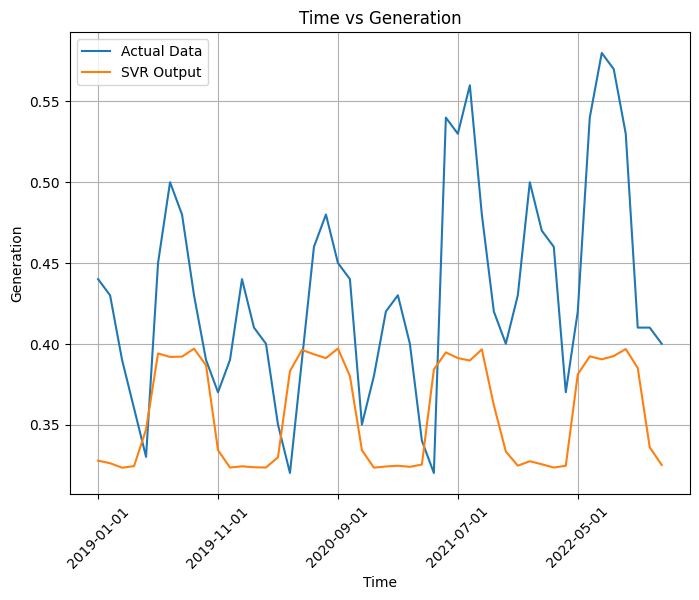


MSE on test dataset: 0.01%

MAPE on test dataset: 18.13%


In [28]:
# Create a pipeline with scaling and SVM
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data
    # ('svm', SVR(kernel='rbf', C=1, epsilon=0.1, gamma=0.01))  # Support Vector Machine model
    ('svm', SVR(kernel='sigmoid'))  # Support Vector Machine model
])

svr_pipeline.fit(feature_ToTrain, target_ToTrain)
predictions = svr_pipeline.predict(feature_ToTest)


# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(x_Time, target_ToTest, linestyle='-', label="Actual Data")
plt.plot(x_Time, predictions, linestyle='-', label="SVR Output")

n = 10
plt.xticks(np.arange(0, len(x_Time), n), [x_Time[i] for i in range(0, len(x_Time), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

mse = mean_squared_error(target_ToTest, predictions)
print(f'\nMSE on test dataset: {mse:.2f}%')

mape = mean_absolute_percentage_error(target_ToTest, predictions)
print(f'\nMAPE on test dataset: {mape:.2f}%')

Since the model is still not satisfactory - the NuSVR is going to be tested.

**Nu Support Vector Regression.**

Similar to NuSVC, for regression, uses a parameter nu to control the number of support vectors. However, unlike NuSVC, where nu replaces C, here nu replaces the parameter epsilon of epsilon-SVR.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html#sklearn.svm.NuSVR


gamma{‘scale’, ‘auto’} or float, default=’scale’
Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
if ‘auto’, uses 1 / n_features
if float, must be non-negative.

C:\Users\spichr01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



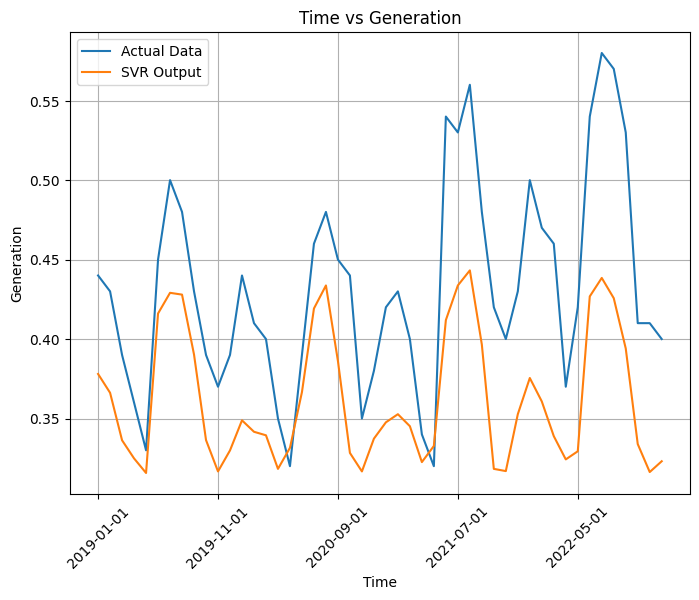


MSE on test dataset: 0.01%

MAPE on test dataset: 18.32%


In [27]:
#Swap between selected Features to analyse the differences in the output
# selectedFeatures = ['GDP_mln','tmax', 'Population_k','Renewables_Production_GWh','Imports_GWh']
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']  

feature_ToTrain = training_data[selectedFeatures]
target_ToTrain = training_data[selectedTarget]

feature_ToTrain = feature_ToTrain.to_numpy()
target_ToTrain = target_ToTrain.to_numpy().ravel()

feature_ToTest = test_data[selectedFeatures]
target_ToTest = test_data[selectedTarget]

# Create a pipeline with scaling and SVM
#when having only tmax as a feature, nu = 0.048 works best. However as soon as the other features are added, the performance decreases drastically, meaning that the model is being overfitted. nu=0.5 has a much better output when multiple features are used
nu_svr_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('nu_svr', NuSVR(nu=0.048, kernel='rbf', degree=2))
    # ('nu_svr', NuSVR(nu=0.5, kernel='rbf', degree=2))  
])

nu_svr_pipeline.fit(feature_ToTrain, target_ToTrain)
nu_predictions = nu_svr_pipeline.predict(feature_ToTest)


# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(x_Time, target_ToTest, linestyle='-', label="Actual Data")
plt.plot(x_Time, nu_predictions, linestyle='-', label="SVR Output")

n = 10
plt.xticks(np.arange(0, len(x_Time), n), [x_Time[i] for i in range(0, len(x_Time), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

mse = mean_squared_error(target_ToTest, nu_predictions)
print(f'\nMSE on test dataset: {mse:.2f}%')

mape = mean_absolute_percentage_error(target_ToTest, nu_predictions)
print(f'\nMAPE on test dataset: {mape:.2f}%')

C:\Users\spichr01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



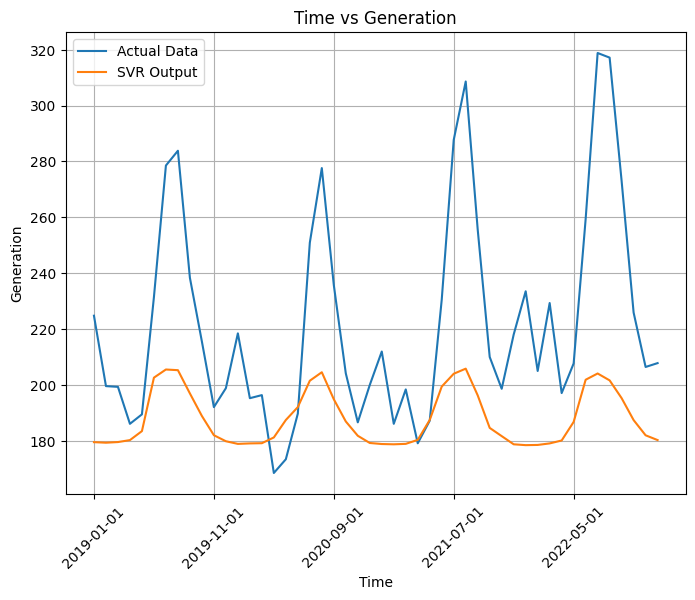


MSE on test dataset: 2139.42%

MAPE on test dataset: 15.34%


In [25]:
#Swap between selected Features to analyse the differences in the output
selectedFeatures = ['tmax', 'Population_k']
selectedTarget = ['Plant_Production_GWh']   #CHOOSING DIFFERENT SELECTED TARGET

feature_ToTrain = training_data[selectedFeatures]
target_ToTrain = training_data[selectedTarget]

feature_ToTrain = feature_ToTrain.to_numpy()
target_ToTrain = target_ToTrain.to_numpy().ravel()

feature_ToTest = test_data[selectedFeatures]
target_ToTest = test_data[selectedTarget]

# Create a pipeline with scaling and SVM
#when having only tmax as a feature, nu = 0.048 works best. However as soon as the other features are added, the performance decreases drastically, meaning that the model is being overfitted. nu=0.5 has a much better output when multiple features are used
nu_svr_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    # ('nu_svr', NuSVR(nu=0.048, kernel='rbf', degree=2))
    ('nu_svr', NuSVR(nu=1, kernel='sigmoid', degree=2))  
])

nu_svr_pipeline.fit(feature_ToTrain, target_ToTrain)
nu_predictions = nu_svr_pipeline.predict(feature_ToTest)


# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(x_Time, target_ToTest, linestyle='-', label="Actual Data")
plt.plot(x_Time, nu_predictions, linestyle='-', label="SVR Output")

n = 10
plt.xticks(np.arange(0, len(x_Time), n), [x_Time[i] for i in range(0, len(x_Time), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

mse = mean_squared_error(target_ToTest, nu_predictions)
print(f'\nMSE on test dataset: {mse:.2f}%')


mape = mean_absolute_percentage_error(target_ToTest, nu_predictions)
print(f'\nMAPE on test dataset: {mape:.2f}%')